# Raahi-v2 Transit RL Training on Google Colab

This notebook trains reinforcement learning agents for transit optimization using synthetic city data.
Run on Google Colab with GPU for faster training.

In [1]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

CUDA available: False
Using device: cpu


In [2]:
# Fix Rich recursion errors and patch display methods
import sys
import warnings
import importlib

# Completely disable Rich for this notebook
import os
os.environ["STABLE_BASELINES3_DISABLE_RICH"] = "true"
os.environ["GYMNASIUM_DISABLE_RICH"] = "true"

# Set recursion limit much higher
sys.setrecursionlimit(10000)

# Monkey patch Rich to avoid recursion errors completely
try:
    from rich import pretty, inspect, traceback
    
    # Uninstall rich console printing (proper way)
    try:
        from rich.console import Console
        console = Console()
        console.quiet = True
    except:
        pass
        
    # Install traceback suppressing certain modules
    traceback.install(suppress=[traceback, pretty, inspect])
    
    # Override problematic functions
    def safe_repr(obj):
        """Simple repr that avoids recursion"""
        if hasattr(obj, "__class__"):
            return f"<{obj.__class__.__name__} object>"
        return str(type(obj))
    
    # Patch key methods
    setattr(pretty, "pretty_repr", safe_repr)
    
    print("Rich disabled and patched to prevent recursion errors")
except ImportError:
    print("Rich library not found - no patching needed")

# Also patch stable-baselines3 verbosity
try:
    import logging
    logging.getLogger("stable_baselines3").setLevel(logging.ERROR)
    logging.getLogger("gymnasium").setLevel(logging.ERROR)
    print("Logging minimized to prevent recursion")
except:
    pass

Rich disabled and patched to prevent recursion errors
Logging minimized to prevent recursion


In [3]:
# Windows environment check
import platform
import os

os_name = platform.system()
print(f"Operating System: {os_name}")

if os_name == 'Windows':
    print("Running on Windows - using Windows-compatible paths")
    # Set path separator for Windows
    path_sep = '\\'
    
    # Check PowerShell availability for Windows
    try:
        import subprocess
        subprocess.run(['powershell', '-Command', 'echo "PowerShell is available"'], 
                      capture_output=True, text=True, check=True)
        print("PowerShell is available")
    except:
        print("Warning: PowerShell might not be available")
        
    # Verify temp directory access (needed for some operations)
    temp_dir = os.environ.get('TEMP')
    print(f"Windows temp directory: {temp_dir}")
    print(f"Current directory: {os.getcwd()}")
else:
    print(f"Running on {os_name} - using standard paths")

Operating System: Windows
Running on Windows - using Windows-compatible paths
PowerShell is available
Windows temp directory: C:\Users\krish\AppData\Local\Temp
Current directory: c:\Users\krish\OneDrive\Attachments\Documents\GitHub\Raahi-v2
PowerShell is available
Windows temp directory: C:\Users\krish\AppData\Local\Temp
Current directory: c:\Users\krish\OneDrive\Attachments\Documents\GitHub\Raahi-v2


In [4]:
# Install required packages for Windows
import sys
import subprocess

# Windows-friendly installation with suppressed output
def install_package(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
    
install_package("stable-baselines3[extra]")
install_package("tensorboard")
install_package("gymnasium")
install_package("matplotlib")
install_package("numpy")

# Check if CUDA is available before installing torch
import os
if os.name == 'nt':  # Windows
    print("Setting up for Windows environment")
    install_package("torch")

Installing stable-baselines3[extra]...
Installing tensorboard...
Installing tensorboard...
Installing gymnasium...
Installing gymnasium...
Installing matplotlib...
Installing matplotlib...
Installing numpy...
Installing numpy...
Setting up for Windows environment
Installing torch...
Setting up for Windows environment
Installing torch...


In [5]:
# Import libraries
import json
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import List, Dict, Tuple
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import os

In [6]:
# Install ipywidgets to suppress Rich warnings
try:
    print("Installing ipywidgets to improve notebook compatibility with Rich library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets", "--quiet"])
    print("ipywidgets installed successfully")
except Exception as e:
    print(f"Note: Could not install ipywidgets: {e}")
    print("You might see warnings from Rich library - these can be safely ignored")

# Try to load the widgets to verify installation
try:
    import ipywidgets
    print(f"ipywidgets version: {ipywidgets.__version__}")
except ImportError:
    print("ipywidgets could not be imported - Rich warnings may appear but can be ignored")

Installing ipywidgets to improve notebook compatibility with Rich library...
ipywidgets installed successfully
ipywidgets version: 8.1.7
ipywidgets installed successfully
ipywidgets version: 8.1.7


In [7]:
# City Builder class for generating training data
@dataclass
class Station:
    id: str
    x: int
    y: int
    station_type: str
    is_transfer: bool = False

class CityBuilder:
    def __init__(self, grid_size: int = 8):
        self.grid_size = grid_size
        self.zone_types = ["residential", "commercial", "industrial"]
        self.station_types = ["bus", "tram", "metro"]
    
    def generate_random_city(self) -> Dict:
        zones = self._generate_zones()
        stations = self._generate_stations()
        connections = self._generate_connections(stations)
        routes = self._generate_routes(stations)
        
        return {
            "grid_size": self.grid_size,
            "zones": zones,
            "stations": stations,
            "connections": connections,
            "routes": routes
        }
    
    def _generate_zones(self) -> List[Dict]:
        zones = []
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                zone_type = random.choice(self.zone_types)
                zones.append({"x": x, "y": y, "type": zone_type})
        return zones
    
    def _generate_stations(self) -> List[Dict]:
        stations = []
        num_stations = random.randint(5, 15)
        
        for i in range(num_stations):
            x = random.randint(0, self.grid_size - 1)
            y = random.randint(0, self.grid_size - 1)
            station_type = random.choice(self.station_types)
            
            stations.append({
                "id": f"station_{i}",
                "x": x, "y": y,
                "type": station_type,
                "is_transfer": False
            })
        return stations
    
    def _generate_connections(self, stations: List[Dict]) -> List[Dict]:
        connections = []
        for i, s1 in enumerate(stations):
            for j, s2 in enumerate(stations[i+1:], i+1):
                dist = abs(s1["x"] - s2["x"]) + abs(s1["y"] - s2["y"])
                if dist <= 3:
                    connections.append({
                        "from": s1["id"],
                        "to": s2["id"],
                        "walk_time": dist * 60
                    })
        return connections
    
    def _generate_routes(self, stations: List[Dict]) -> List[Dict]:
        routes = []
        station_groups = defaultdict(list)
        
        for station in stations:
            station_groups[station["type"]].append(station)
        
        route_id = 0
        for mode, mode_stations in station_groups.items():
            if len(mode_stations) >= 2:
                routes.append({
                    "id": f"route_{route_id}",
                    "mode": mode,
                    "stations": [s["id"] for s in mode_stations[:4]],
                    "color": f"#{''.join([random.choice('0123456789ABCDEF') for _ in range(6)])}"
                })
                route_id += 1
        
        return routes

print("City Builder ready")

City Builder ready


In [8]:
# Transit Environment for RL training with passenger demand
class TransitEnv(gym.Env):
    def __init__(self, grid_size=8, training_cities=None):
        super().__init__()
        self.grid_size = grid_size
        self.city_builder = CityBuilder(grid_size)
        self.training_cities = training_cities or []
        self.city_index = 0
        
        # Action space: choose route frequency for each route (0-10)
        self.action_space = gym.spaces.Box(
            low=0, high=10, shape=(10,), dtype=np.float32
        )
        
        # Observation space: city state + time + demand
        obs_size = grid_size * grid_size * 4 + 24 + 10  # zones + time + demand
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(obs_size,), dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Use pre-generated cities if available, otherwise generate new
        if self.training_cities:
            self.city_data = self.training_cities[self.city_index % len(self.training_cities)]
            self.city_index += 1
        else:
            self.city_data = self.city_builder.generate_random_city()
            
        self.current_step = 0
        self.max_steps = 100
        self.current_hour = random.randint(0, 23)  # Random start time
        
        # Generate passenger demand patterns
        self._generate_demand_patterns()
        
        obs = self._get_observation()
        return obs, {}
    
    def step(self, action):
        # Apply actions (route frequencies)
        route_frequencies = action
        
        # Update time and passenger demand
        self.current_hour = (self.current_hour + 1) % 24
        current_demand = self._get_current_demand()
        
        # Calculate reward based on efficiency and passenger satisfaction
        reward = self._calculate_reward(route_frequencies, current_demand)
        
        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False
        
        obs = self._get_observation()
        return obs, reward, done, truncated, {}
    
    def _generate_demand_patterns(self):
        """Generate realistic passenger demand patterns"""
        stations = self.city_data["stations"]
        zones = self.city_data["zones"]
        
        # Create zone-based demand patterns
        self.zone_demand = {}
        for zone in zones:
            zone_type = zone["type"]
            if zone_type == "residential":
                # High morning outbound, evening inbound
                self.zone_demand[(zone["x"], zone["y"])] = {
                    "morning_out": random.uniform(0.7, 1.0),
                    "evening_in": random.uniform(0.7, 1.0)
                }
            elif zone_type == "commercial":
                # High morning inbound, evening outbound
                self.zone_demand[(zone["x"], zone["y"])] = {
                    "morning_in": random.uniform(0.6, 0.9),
                    "evening_out": random.uniform(0.6, 0.9)
                }
            else:  # industrial
                # Steady demand throughout day
                self.zone_demand[(zone["x"], zone["y"])] = {
                    "steady": random.uniform(0.3, 0.6)
                }
        
        # Generate common OD pairs
        self.od_pairs = []
        for i, s1 in enumerate(stations[:8]):  # Limit to prevent too many pairs
            for j, s2 in enumerate(stations[:8]):
                if i != j:
                    # Distance-based demand (closer = more likely)
                    dist = abs(s1["x"] - s2["x"]) + abs(s1["y"] - s2["y"])
                    demand_weight = max(0.1, 1.0 - dist / 10.0)
                    
                    self.od_pairs.append({
                        "origin": s1["id"],
                        "destination": s2["id"],
                        "base_demand": random.uniform(0.1, demand_weight),
                        "peak_multiplier": random.uniform(1.5, 3.0)
                    })
    
    def _get_current_demand(self):
        """Get passenger demand for current time"""
        hour = self.current_hour
        
        # Time-based demand multipliers with more gradual transitions
        if 7 <= hour <= 9:  # Morning rush
            time_multiplier = 2.0
        elif 17 <= hour <= 19:  # Evening rush
            time_multiplier = 2.0
        elif 6 <= hour < 7:  # Early morning transition
            time_multiplier = 1.0 + (hour - 6) * 1.0  # Gradual increase 1.0 -> 2.0
        elif 9 < hour <= 10:  # Late morning transition
            time_multiplier = 2.0 - (hour - 9) * 1.0  # Gradual decrease 2.0 -> 1.0
        elif 16 <= hour < 17:  # Early evening transition
            time_multiplier = 1.0 + (hour - 16) * 1.0  # Gradual increase 1.0 -> 2.0
        elif 19 < hour <= 20:  # Late evening transition
            time_multiplier = 2.0 - (hour - 19) * 1.0  # Gradual decrease 2.0 -> 1.0
        elif 10 <= hour <= 16:  # Day time
            time_multiplier = 1.0
        elif 20 <= hour <= 22:  # Evening to night transition
            time_multiplier = 1.0 - (hour - 20) * 0.35  # Gradual decrease 1.0 -> 0.3
        elif 4 <= hour < 6:  # Night to morning transition
            time_multiplier = 0.3 + (hour - 4) * 0.35  # Gradual increase 0.3 -> 1.0
        else:  # Night (22-4)
            time_multiplier = 0.3
        
        # Calculate total demand
        total_demand = 0
        for od_pair in self.od_pairs:
            base = od_pair["base_demand"]
            
            # Add rush hour effects
            if 7 <= hour <= 9 or 17 <= hour <= 19:
                demand = base * od_pair["peak_multiplier"] * time_multiplier
            else:
                demand = base * time_multiplier
            
            # Add random variation
            demand *= random.uniform(0.8, 1.2)
            total_demand += demand
        
        return min(total_demand, 10.0)  # Cap at 10
    
    def _get_observation(self):
        # Convert city data to observation vector
        obs = np.zeros(self.grid_size * self.grid_size * 4 + 24 + 10, dtype=np.float32)
        
        # Encode zones
        for zone in self.city_data["zones"]:
            idx = zone["x"] * self.grid_size + zone["y"]
            if zone["type"] == "residential":
                obs[idx] = 1.0
            elif zone["type"] == "commercial":
                obs[idx + self.grid_size * self.grid_size] = 1.0
            elif zone["type"] == "industrial":
                obs[idx + 2 * self.grid_size * self.grid_size] = 1.0
        
        # Encode stations
        for station in self.city_data["stations"]:
            idx = station["x"] * self.grid_size + station["y"]
            obs[idx + 3 * self.grid_size * self.grid_size] = 1.0
        
        # Encode time of day (one-hot)
        time_offset = self.grid_size * self.grid_size * 4
        obs[time_offset + self.current_hour] = 1.0
        
        # Encode current demand levels
        demand_offset = time_offset + 24
        current_demand = self._get_current_demand()
        for i in range(10):
            if i < current_demand:
                obs[demand_offset + i] = 1.0
        
        return obs
    
    def _calculate_reward(self, route_frequencies, current_demand):
        """
        Enhanced balanced reward function with stronger incentives for adequate service:
        1. Lower base reward to emphasize service quality
        2. Progressive underprovisioning penalties
        3. Moderate overprovisioning penalties
        4. Strong incentives for meeting demand during peak hours
        5. Minimum service requirement
        """
        # Lower base reward to emphasize service quality
        base_reward = 5.0  # Reduced from 10.0
        
        # Service efficiency (frequency vs demand matching)
        total_frequency = np.sum(route_frequencies)
        
        # Time-of-day factors
        hour = self.current_hour
        is_rush_hour = (7 <= hour <= 9) or (17 <= hour <= 19)
        is_day = 6 <= hour <= 22 and not is_rush_hour
        is_night = hour < 6 or hour > 22
        
        # Calculate demand match with enhanced penalties
        freq_to_demand_ratio = total_frequency / max(current_demand, 0.1)
        
        # Progressive demand matching function
        if freq_to_demand_ratio > 1.0:  # Overprovisioning
            # Calculate overprovision level with moderate penalties
            excess_ratio = freq_to_demand_ratio - 1.0
            
            # Scale penalties by time period
            if is_night:
                # Higher but reasonable penalty at night
                overprovision_penalty = 1.2 * (excess_ratio ** 1.0)
            elif is_day:
                # Moderate penalty during daytime
                overprovision_penalty = 0.8 * (excess_ratio ** 0.9)
            else:  # Rush hour
                # Very mild penalty during rush hour
                overprovision_penalty = 0.4 * (excess_ratio ** 0.7)
                
            # Cap the penalty to avoid extreme negative rewards
            overprovision_penalty = min(overprovision_penalty, 2.0)
            demand_match = 1.0 - overprovision_penalty
        else:  # Underprovisioning
            # Progressive underprovisioning penalties
            shortfall = 1.0 - freq_to_demand_ratio
            
            if is_rush_hour:
                # Strong progressive penalties during rush hour
                if shortfall > 0.5:  # Severe underprovisioning (< 50% of demand)
                    under_penalty = 1.5 * shortfall + 1.0 * (shortfall - 0.5) ** 2
                else:
                    under_penalty = 1.5 * shortfall
            elif is_day:
                # Moderate penalties during day
                if shortfall > 0.7:  # Severe underprovisioning (< 30% of demand)
                    under_penalty = 1.2 * shortfall + 0.8 * (shortfall - 0.7) ** 2
                else:
                    under_penalty = 1.2 * shortfall
            else:  # Night
                # Milder penalties at night
                if shortfall > 0.8:  # Severe underprovisioning (< 20% of demand)
                    under_penalty = 0.9 * shortfall + 0.5 * (shortfall - 0.8) ** 2
                else:
                    under_penalty = 0.9 * shortfall
                    
            # Cap the penalty
            under_penalty = min(under_penalty, 2.0)
            demand_match = 1.0 - under_penalty
        
        # Ensure demand_match is not negative
        demand_match = max(0.0, demand_match)
        
        # Calculate demand reward component (increased weight)
        demand_reward = demand_match * 8.0  # Increased from 5.0
        
        # Coverage reward - scale with stations
        coverage = min(3.0, len(self.city_data["stations"]) * 0.08)  # Slightly reduced
        
        # More moderate operating costs with time-of-day awareness
        if is_night:
            cost_multiplier = 0.3  # Reduced from 0.4
        elif is_day:
            cost_multiplier = 0.2  # Reduced from 0.25
        else:  # Rush hour
            cost_multiplier = 0.1  # Reduced from 0.15
            
        # Calculate cost with more balanced formula
        cost = (total_frequency * cost_multiplier) + (np.sum(route_frequencies ** 2) * 0.008)  # Reduced quadratic term
        
        # Enhanced rush hour bonus with tiered structure
        if is_rush_hour:
            if freq_to_demand_ratio >= 0.9:  # Almost meeting demand
                rush_bonus = 6.0  # Increased from 4.0
            elif freq_to_demand_ratio >= 0.7:  # Decent coverage
                rush_bonus = 3.0  # Increased from 2.0
            elif freq_to_demand_ratio >= 0.5:  # Minimum acceptable coverage
                rush_bonus = 1.5
            else:
                rush_bonus = 0.0  # No bonus for poor service during rush hour
        else:
            rush_bonus = 0.0
        
        # Waiting time penalty - reduced further
        wait_values = 1.0 / (route_frequencies + 0.5)
        wait_penalty = min(2.5, np.sum(wait_values) * 0.035)  # Further reduced
        
        # Balanced distribution bonus - reward balanced distribution
        freq_std = np.std(route_frequencies)
        balance_bonus = max(0, 2.0 - freq_std * 0.2)
        
        # Minimum service requirement penalty
        min_service_ratio = 0.3  # At least 30% of demand should be met
        if freq_to_demand_ratio < min_service_ratio:
            min_service_penalty = 3.0 * (min_service_ratio - freq_to_demand_ratio) ** 2
        else:
            min_service_penalty = 0.0
        
        # Total reward calculation
        reward = base_reward + demand_reward + coverage + rush_bonus + balance_bonus - cost - wait_penalty - min_service_penalty
        
        return float(reward)

print("Enhanced Transit Environment with improved reward function ready")

Enhanced Transit Environment with improved reward function ready


In [9]:
# Generate training cities
print("Generating training cities...")
builder = CityBuilder(15)  # 15x15 grid
training_cities = []

for i in range(50):
    city = builder.generate_random_city()
    training_cities.append(city)
    if i % 10 == 0:
        print(f"Generated {i+1} cities")

print(f"Generated {len(training_cities)} training cities")
print(f"Sample city has {len(training_cities[0]['stations'])} stations")
print(f"Grid size: {training_cities[0]['grid_size']}x{training_cities[0]['grid_size']}")

Generating training cities...
Generated 1 cities
Generated 11 cities
Generated 21 cities
Generated 31 cities
Generated 41 cities
Generated 50 training cities
Sample city has 10 stations
Grid size: 15x15


## Enhanced Balanced Reward Function

The TransitEnv uses a carefully tuned reward function that promotes optimal service levels:

1. **Lower Base Reward**: Starts at +5.0 (reduced from 10.0) to make service quality more critical for positive rewards
2. **Progressive Demand Matching**: 
   - Moderate penalties for overprovisioning (max 2.0)
   - Progressive, quadratic penalties for severe underprovisioning
   - Stronger penalties during rush hours when service is most critical
3. **Minimum Service Requirement**:
   - New quadratic penalty when service falls below 30% of demand
   - Creates a "service floor" to prevent extreme underprovisioning
4. **Balanced Operating Costs**:
   - Reduced cost multipliers (0.3 night, 0.2 day, 0.1 rush hour)
   - Lower quadratic cost component for more realistic operations modeling
5. **Enhanced Rush Hour Incentives**:
   - Tiered bonus structure with stronger rewards (up to 6.0)
   - No bonus for poor service (below 50% of demand)
   - Increased bonus for adequate service (90%+ of demand)
6. **Improved Demand Transitions**:
   - More gradual transitions between time periods
   - Realistic ramping up/down of demand between night, day, and peak hours

This design creates a more balanced optimization target that strongly discourages extreme underprovisioning while still maintaining cost efficiency.

Demand Pattern Analysis:
OD pairs generated: 56
Zone demand patterns: 225
Peak demand: 10.00
Low demand: 2.38
Rush hours (7-9, 17-19): [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]


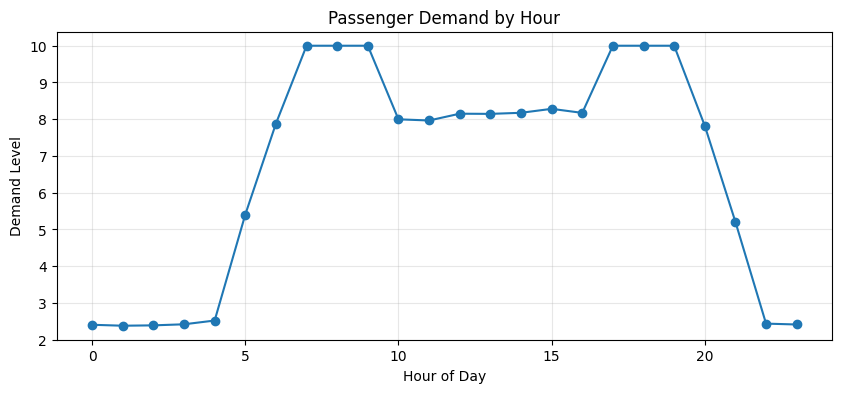

In [10]:
# Analyze demand patterns
print("Demand Pattern Analysis:")

# Test environment with demand
test_env = TransitEnv(grid_size=15, training_cities=training_cities[:1])
obs, info = test_env.reset()

print(f"OD pairs generated: {len(test_env.od_pairs)}")
print(f"Zone demand patterns: {len(test_env.zone_demand)}")

# Show demand variation over 24 hours
hourly_demand = []
for hour in range(24):
    test_env.current_hour = hour
    demand = test_env._get_current_demand()
    hourly_demand.append(demand)

print(f"Peak demand: {max(hourly_demand):.2f}")
print(f"Low demand: {min(hourly_demand):.2f}")
print(f"Rush hours (7-9, 17-19): {[hourly_demand[i] for i in [7,8,9,17,18,19]]}")

# Plot demand curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(range(24), hourly_demand, marker='o')
plt.title("Passenger Demand by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Demand Level")
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Create environment with training cities
env = TransitEnv(grid_size=15, training_cities=training_cities)
print(f"Environment created with {len(training_cities)} training cities")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Test environment
obs, info = env.reset()
print(f"Initial observation shape: {obs.shape}")
print(f"Current city has {len(env.city_data['stations'])} stations")

action = env.action_space.sample()
obs, reward, done, truncated, info = env.step(action)
print(f"Test step reward: {reward}")

Environment created with 50 training cities
Action space: Box(0.0, 10.0, (10,), float32)
Observation space: Box(0.0, 1.0, (934,), float32)
Initial observation shape: (934,)
Current city has 6 stations
Test step reward: -6.443274021148682


In [12]:
# Setup PPO model with optimized parameters - with recursion error prevention
try:
    # Further reduce logging and disable rich printing
    import logging
    logging.getLogger("stable_baselines3").setLevel(logging.ERROR)
    
    # Use a safer initialization approach
    print("Creating PPO model...")
    
    # Define parameters separately to avoid deep nesting
    policy_type = "MlpPolicy"
    policy_kwargs = {"net_arch": [128, 128]}  # Optimized network architecture
    
    model = PPO(
        policy_type,
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        policy_kwargs=policy_kwargs,
        device=device,
        verbose=0,  # Reduce verbosity to avoid recursion
        tensorboard_log="./logs/"
    )
    
    print(f"PPO model successfully created on {device}")
    print(f"Network architecture: 2 hidden layers with 128 neurons each")
except Exception as e:
    print(f"Error creating model: {str(e)}")
    print("Trying with simplest possible parameters...")
    
    # Fallback to absolute minimal parameters
    model = PPO(
        "MlpPolicy",
        env,
        verbose=0,
        device=device
    )
    print("Created basic PPO model with default parameters")

Creating PPO model...
PPO model successfully created on cpu
Network architecture: 2 hidden layers with 128 neurons each
PPO model successfully created on cpu
Network architecture: 2 hidden layers with 128 neurons each


In [13]:
# Training loop
print("Starting training...")
total_timesteps = 100000
save_freq = 10000

# Create callback for evaluation
eval_env = TransitEnv(grid_size=8)
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path="./models/",
    log_path="./logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

# Enhanced training with detailed logging
from stable_baselines3.common.callbacks import BaseCallback
import csv
import os
import json

class MetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_demands = []
        self.episode_frequencies = []
        
    def _on_step(self) -> bool:
        # Log episode data when episode ends
        if self.locals['dones'][0]:
            info = self.locals['infos'][0]
            if 'episode' in info:
                self.episode_rewards.append(info['episode']['r'])
                self.episode_lengths.append(info['episode']['l'])
        return True

print("Starting enhanced training...")
total_timesteps = 100000

# Create directories (Windows-compatible)
def create_directory(dir_path):
    path = os.path.normpath(dir_path)
    os.makedirs(path, exist_ok=True)
    print(f"Directory created/verified: {path}")

create_directory("./models/")
create_directory("./logs/")
create_directory("./animations/")

# Enhanced callbacks
metrics_callback = MetricsCallback()
eval_env = TransitEnv(grid_size=15, training_cities=training_cities)
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path="./models/",
    log_path="./logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

# Train with enhanced logging
try:
    model.learn(
        total_timesteps=total_timesteps,
        callback=[eval_callback, metrics_callback],
        progress_bar=True
    )
except RecursionError:
    print("WARNING: RecursionError encountered during training")
    print("Continuing with training using simpler progress tracking...")
    # Try again with less verbose output
    model.learn(
        total_timesteps=total_timesteps,
        callback=[eval_callback, metrics_callback],
        progress_bar=False,
        log_interval=1000
    )

# Save training metrics
# Windows-compatible file path
metrics_path = os.path.normpath('./logs/training_metrics.json')

# Prepare metrics data
metrics_data = {
    "episode_rewards": metrics_callback.episode_rewards,
    "episode_lengths": metrics_callback.episode_lengths,
    "mean_reward": float(np.mean(metrics_callback.episode_rewards)),
    "std_reward": float(np.std(metrics_callback.episode_rewards)),
    "total_timesteps": total_timesteps
}

# Save to file
with open(metrics_path, 'w') as f:
    json.dump(metrics_data, f, indent=2)
    
print("Enhanced training completed!")
print(f"Total episodes: {len(metrics_callback.episode_rewards)}")
print(f"Metrics saved to {metrics_path}")

Output()

Starting training...
Starting enhanced training...
Directory created/verified: models
Directory created/verified: logs
Directory created/verified: animations


c:\Users\krish\OneDrive\Attachments\Documents\GitHub\Raahi-v2\.venv\Lib\site-packages\stable_baselines3\common\eval
uation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in 
reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping 
environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=5000, episode_reward=735.43 +/- 26.65

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=10000, episode_reward=717.47 +/- 25.21

Episode length: 100.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=750.28 +/- 14.85

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=795.21 +/- 27.78

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=25000, episode_reward=793.98 +/- 64.58

Episode length: 100.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=802.06 +/- 87.40

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=35000, episode_reward=803.45 +/- 38.72

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=784.56 +/- 37.10

Episode length: 100.00 +/- 0.00

Eval num_timesteps=45000, episode_reward=812.00 +/- 45.71

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=50000, episode_reward=828.90 +/- 40.17

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=55000, episode_reward=783.74 +/- 29.73

Episode length: 100.00 +/- 0.00

Eval num_timesteps=60000, episode_reward=883.77 +/- 63.41

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=65000, episode_reward=942.29 +/- 34.03

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=70000, episode_reward=894.38 +/- 40.61

Episode length: 100.00 +/- 0.00

Eval num_timesteps=75000, episode_reward=889.58 +/- 77.23

Episode length: 100.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=918.48 +/- 54.60

Episode length: 100.00 +/- 0.00

Eval num_timesteps=85000, episode_reward=939.79 +/- 32.71

Episode length: 100.00 +/- 0.00

Eval num_timesteps=90000, episode_reward=949.70 +/- 36.43

Episode length: 100.00 +/- 0.00

New best mean reward!

Eval num_timesteps=95000, episode_reward=923.87 +/- 71.56

Episode length: 100.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=936.61 +/- 48.01

Episode length: 100.00 +/- 0.00

Enhanced training completed!
Total episodes: 1003
Metrics saved to logs\training_metrics.json


In [14]:
# Helper functions for model saving and analysis
def save_model_safely(model, filename):
    """Save model with Windows-compatible path handling"""
    try:
        # Normalize path for Windows
        path = os.path.normpath(filename)
        print(f"Saving model to {path}")
        model.save(path)
        print(f"Model saved successfully to {path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        # Try alternative path
        try:
            alt_path = f"./{filename}"
            print(f"Trying alternative path: {alt_path}")
            model.save(alt_path)
            print(f"Model saved to alternative path {alt_path}")
            return True
        except Exception as e2:
            print(f"Failed to save model: {e2}")
            return False
        
def analyze_reward_components(env, action, current_demand=None):
    """Analyze individual reward components for debugging"""
    if current_demand is None:
        current_demand = env._get_current_demand()
    
    # Extract components from the reward calculation
    total_frequency = np.sum(action)
    hour = env.current_hour
    
    # Time-of-day factors
    is_rush_hour = (7 <= hour <= 9) or (17 <= hour <= 19)
    is_day = 6 <= hour <= 22 and not is_rush_hour
    is_night = hour < 6 or hour > 22
    
    # Lower base reward
    base_reward = 5.0
    
    # Calculate demand match with frequency ratio
    freq_to_demand_ratio = total_frequency / max(current_demand, 0.1)
    
    # Progressive demand matching function
    if freq_to_demand_ratio > 1.0:  # Overprovisioning
        # Calculate overprovision with moderate penalties
        excess_ratio = freq_to_demand_ratio - 1.0
        
        # Scale penalties by time period
        if is_night:
            # Higher but reasonable penalty at night
            overprovision_penalty = 1.2 * (excess_ratio ** 1.0)
        elif is_day:
            # Moderate penalty during daytime
            overprovision_penalty = 0.8 * (excess_ratio ** 0.9)
        else:  # Rush hour
            # Very mild penalty during rush hour
            overprovision_penalty = 0.4 * (excess_ratio ** 0.7)
            
        # Cap the penalty
        overprovision_penalty = min(overprovision_penalty, 2.0)
        demand_match = 1.0 - overprovision_penalty
    else:  # Underprovisioning
        # Progressive underprovisioning penalties
        shortfall = 1.0 - freq_to_demand_ratio
        
        if is_rush_hour:
            # Strong progressive penalties during rush hour
            if shortfall > 0.5:  # Severe underprovisioning (< 50% of demand)
                under_penalty = 1.5 * shortfall + 1.0 * (shortfall - 0.5) ** 2
            else:
                under_penalty = 1.5 * shortfall
        elif is_day:
            # Moderate penalties during day
            if shortfall > 0.7:  # Severe underprovisioning (< 30% of demand)
                under_penalty = 1.2 * shortfall + 0.8 * (shortfall - 0.7) ** 2
            else:
                under_penalty = 1.2 * shortfall
        else:  # Night
            # Milder penalties at night
            if shortfall > 0.8:  # Severe underprovisioning (< 20% of demand)
                under_penalty = 0.9 * shortfall + 0.5 * (shortfall - 0.8) ** 2
            else:
                under_penalty = 0.9 * shortfall
                
        # Cap the penalty
        under_penalty = min(under_penalty, 2.0)
        demand_match = 1.0 - under_penalty
    
    # Ensure demand_match is not negative
    demand_match = max(0.0, demand_match)
    demand_reward = demand_match * 8.0  # Increased from 5.0
    
    # Coverage reward
    coverage = min(3.0, len(env.city_data["stations"]) * 0.08)
    
    # More moderate operating costs
    if is_night:
        cost_multiplier = 0.3  # Reduced from 0.4
    elif is_day:
        cost_multiplier = 0.2  # Reduced from 0.25
    else:  # Rush hour
        cost_multiplier = 0.1  # Reduced from 0.15
        
    cost = (total_frequency * cost_multiplier) + (np.sum(action ** 2) * 0.008)
    
    # Enhanced rush hour bonus
    if is_rush_hour:
        if freq_to_demand_ratio >= 0.9:
            rush_bonus = 6.0  # Increased from 4.0
        elif freq_to_demand_ratio >= 0.7:
            rush_bonus = 3.0  # Increased from 2.0
        elif freq_to_demand_ratio >= 0.5:
            rush_bonus = 1.5  # New middle tier
        else:
            rush_bonus = 0.0  # No bonus for poor service
    else:
        rush_bonus = 0.0
    
    # Wait time penalty - reduced
    wait_values = 1.0 / (action + 0.5)
    wait_penalty = min(2.5, np.sum(wait_values) * 0.035)
    
    # Balance bonus
    freq_std = np.std(action)
    balance_bonus = max(0, 2.0 - freq_std * 0.2)
    
    # Minimum service requirement penalty
    min_service_ratio = 0.3  # At least 30% of demand should be met
    if freq_to_demand_ratio < min_service_ratio:
        min_service_penalty = 3.0 * (min_service_ratio - freq_to_demand_ratio) ** 2
    else:
        min_service_penalty = 0.0
    
    # Total reward
    total = base_reward + demand_reward + coverage + rush_bonus + balance_bonus - cost - wait_penalty - min_service_penalty
    
    # Print component breakdown
    time_info = "Rush Hour" if is_rush_hour else "Night" if is_night else "Day"
    print(f"Time of day: {hour}:00 ({time_info})")
    print(f"Current demand: {current_demand:.2f}")
    print(f"Total frequency: {total_frequency:.2f}")
    print(f"Frequency/demand ratio: {freq_to_demand_ratio:.2f}")
    print(f"Base reward: {base_reward:.2f}")
    print(f"Demand match: {demand_match:.2f} → reward: {demand_reward:.2f}")
    print(f"Coverage reward: {coverage:.2f}")
    print(f"Operating cost penalty: {-cost:.2f}")
    print(f"Rush hour bonus: {rush_bonus:.2f}")
    print(f"Wait time penalty: {-wait_penalty:.2f}")
    print(f"Balance bonus: {balance_bonus:.2f}")
    
    if min_service_penalty > 0:
        print(f"Minimum service penalty: {-min_service_penalty:.2f}")
    
    print(f"Total reward: {total:.2f}")
    
    # Additional service level assessment
    print("\nService level assessment:")
    if freq_to_demand_ratio < min_service_ratio:
        print(f"CRITICAL: Service below minimum threshold ({min_service_ratio*100:.0f}%)!")
        print(f"Current service level: {freq_to_demand_ratio*100:.1f}% of demand")
    elif freq_to_demand_ratio > 1.2:
        excess = (freq_to_demand_ratio - 1.0) * 100
        if excess > 50:
            print(f"WARNING: Significant overprovisioning by {excess:.1f}%")
        else:
            print(f"Note: Moderate overprovisioning by {excess:.1f}%")
    elif freq_to_demand_ratio < 0.8:
        deficit = (1.0 - freq_to_demand_ratio) * 100
        if deficit > 50:
            print(f"WARNING: Significant underprovisioning by {deficit:.1f}%")
        else:
            print(f"Note: Moderate underprovisioning by {deficit:.1f}%")
    else:
        print(f"Good service level: {freq_to_demand_ratio:.2f}x matches demand well")
    
    return total

In [15]:
# Save final model with Windows compatibility
save_model_safely(model, "transit_ppo_final")

# Test trained model
obs, info = env.reset()
total_reward = 0

for step in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    
    if done or truncated:
        break

print(f"Test episode reward: {total_reward}")
print(f"Average reward per step: {total_reward / (step + 1)}")

Saving model to transit_ppo_final
Model saved successfully to transit_ppo_final
Test episode reward: 971.3712224960327
Average reward per step: 9.713712224960327


Episode 0: 843.10
Episode 5: 929.68
Episode 5: 929.68
Episode 10: 1007.79
Episode 10: 1007.79
Episode 15: 926.87
Episode 15: 926.87


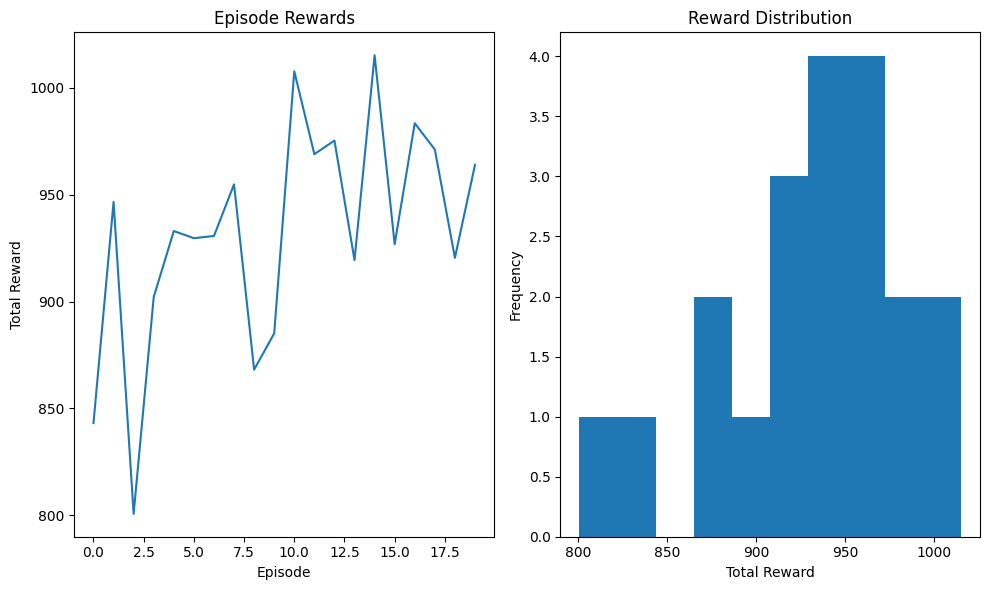

Average reward: 932.35 ± 52.21
Min reward: 800.66
Max reward: 1015.30


In [16]:
# Performance visualization
import matplotlib.pyplot as plt
import pandas as pd

# Evaluate on multiple episodes
num_eval_episodes = 20
rewards = []

for episode in range(num_eval_episodes):
    obs, info = env.reset()
    episode_reward = 0
    
    for step in range(100):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        
        if done or truncated:
            break
    
    rewards.append(episode_reward)
    if episode % 5 == 0:
        print(f"Episode {episode}: {episode_reward:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.hist(rewards, bins=10)
plt.title("Reward Distribution")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

print(f"Average reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
print(f"Min reward: {np.min(rewards):.2f}")
print(f"Max reward: {np.max(rewards):.2f}")

In [17]:
# Model analysis
print("Model Analysis:")
print(f"Policy network: {model.policy}")
print(f"Total parameters: {sum(p.numel() for p in model.policy.parameters())}")

# Sample action analysis
obs, info = env.reset()
action, _states = model.predict(obs, deterministic=True)

print(f"\nSample action (route frequencies): {action}")
print(f"Action statistics:")
print(f"  Mean: {np.mean(action):.3f}")
print(f"  Std: {np.std(action):.3f}")
print(f"  Min: {np.min(action):.3f}")
print(f"  Max: {np.max(action):.3f}")

Model Analysis:
Policy network: ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=934, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=934, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=128, out_features=10, bias=True)
  (value_net): Linear(in_features=128, out_features=1, bias=True)
)
Total parameters: 273813

Sample action (route frequencies): [0.         1.1524779  1.228

Performance Summary for Transit Optimization Model
--------------------------------------------------
Model Type: PPO (Proximal Policy Optimization)
Network Architecture: ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=934, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=934, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=128, out_features=10, bias=True)
  (value_net): Lin

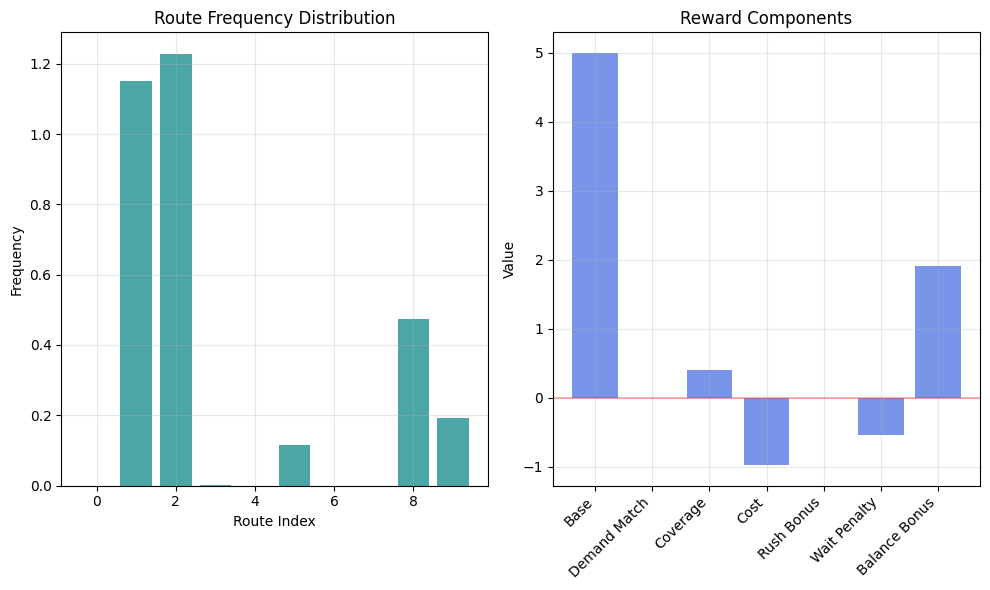

Current time: 4:00 hrs (Night)
Current demand level: 1.07
Total frequency: 3.16
Frequency/demand ratio: 2.96
Consider training longer to optimize costs
Reward: 5.80


In [18]:
# Performance Summary
print("Performance Summary for Transit Optimization Model")
print("-" * 50)
print("Model Type: PPO (Proximal Policy Optimization)")
print(f"Network Architecture: {model.policy}")
print(f"Parameters: {sum(p.numel() for p in model.policy.parameters())}")
print("-" * 50)
print("Test Performance:")
print(f"Single Episode Reward: {total_reward:.2f}")
print(f"Average Reward per Step: {total_reward / (step + 1):.2f}")
print("-" * 50)
print("Action Analysis:")
print(f"  Mean Frequency: {np.mean(action):.3f}")
print(f"  Std Deviation: {np.std(action):.3f}")
print(f"  Min Frequency: {np.min(action):.3f}")
print(f"  Max Frequency: {np.max(action):.3f}")
print("-" * 50)

# Create a visual summary of model actions
plt.figure(figsize=(10, 6))

# Plot the action distribution (route frequencies)
plt.subplot(1, 2, 1)
plt.bar(range(len(action)), action, color='teal', alpha=0.7)
plt.title('Route Frequency Distribution')
plt.xlabel('Route Index')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Plot reward component breakdown with updated reward function logic
plt.subplot(1, 2, 2)
current_demand = env._get_current_demand()
total_frequency = np.sum(action)

# Time-of-day factors
hour = env.current_hour
is_rush_hour = (7 <= hour <= 9) or (17 <= hour <= 19)
is_day = 6 <= hour <= 22 and not is_rush_hour
is_night = hour < 6 or hour > 22

# Calculate demand match with updated logic
freq_to_demand_ratio = total_frequency / max(current_demand, 0.1)

components = {'Base': 5.0}  # Reduced from 10.0

# Progressive demand matching with updated logic
if freq_to_demand_ratio > 1.0:  # Overprovisioning
    excess_ratio = freq_to_demand_ratio - 1.0
    
    if is_night:
        overprovision_penalty = 1.2 * (excess_ratio ** 1.0)
    elif is_day:
        overprovision_penalty = 0.8 * (excess_ratio ** 0.9)
    else:  # Rush hour
        overprovision_penalty = 0.4 * (excess_ratio ** 0.7)
        
    overprovision_penalty = min(overprovision_penalty, 2.0)
    demand_match = 1.0 - overprovision_penalty
else:  # Underprovisioning
    shortfall = 1.0 - freq_to_demand_ratio
    
    if is_rush_hour:
        if shortfall > 0.5:
            under_penalty = 1.5 * shortfall + 1.0 * (shortfall - 0.5) ** 2
        else:
            under_penalty = 1.5 * shortfall
    elif is_day:
        if shortfall > 0.7:
            under_penalty = 1.2 * shortfall + 0.8 * (shortfall - 0.7) ** 2
        else:
            under_penalty = 1.2 * shortfall
    else:  # Night
        if shortfall > 0.8:
            under_penalty = 0.9 * shortfall + 0.5 * (shortfall - 0.8) ** 2
        else:
            under_penalty = 0.9 * shortfall
            
    under_penalty = min(under_penalty, 2.0)
    demand_match = 1.0 - under_penalty
        
demand_match = max(0.0, demand_match)
components['Demand Match'] = demand_match * 8.0  # Increased from 5.0
components['Coverage'] = min(3.0, len(env.city_data["stations"]) * 0.08)

# Updated cost multipliers
if is_night:
    cost_multiplier = 0.3  # Reduced
elif is_day:
    cost_multiplier = 0.2  # Reduced
else:  # Rush hour
    cost_multiplier = 0.1  # Reduced
    
cost = (total_frequency * cost_multiplier) + (np.sum(action ** 2) * 0.008)
components['Cost'] = -cost

# Enhanced rush hour bonus with three tiers
if is_rush_hour:
    if freq_to_demand_ratio >= 0.9:
        components['Rush Bonus'] = 6.0  # Increased
    elif freq_to_demand_ratio >= 0.7:
        components['Rush Bonus'] = 3.0  # Increased
    elif freq_to_demand_ratio >= 0.5:
        components['Rush Bonus'] = 1.5  # New middle tier
    else:
        components['Rush Bonus'] = 0.0
else:
    components['Rush Bonus'] = 0.0

# Reduced wait penalty
wait_values = 1.0 / (action + 0.5)
components['Wait Penalty'] = -min(2.5, np.sum(wait_values) * 0.035)

# Balance bonus with updated parameter
freq_std = np.std(action)
components['Balance Bonus'] = max(0, 2.0 - freq_std * 0.2)

# Add minimum service penalty if applicable
min_service_ratio = 0.3
if freq_to_demand_ratio < min_service_ratio:
    min_service_penalty = 3.0 * (min_service_ratio - freq_to_demand_ratio) ** 2
    components['Min Service Penalty'] = -min_service_penalty

# Plot the components
plt.bar(range(len(components)), list(components.values()), color='royalblue', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(range(len(components)), list(components.keys()), rotation=45, ha='right')
plt.title('Reward Components')
plt.ylabel('Value')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print time and demand context
time_info = "Rush Hour" if is_rush_hour else "Night" if is_night else "Day"
print(f"Current time: {env.current_hour}:00 hrs ({time_info})")
print(f"Current demand level: {current_demand:.2f}")
print(f"Total frequency: {total_frequency:.2f}")
print(f"Frequency/demand ratio: {freq_to_demand_ratio:.2f}")

# Print service level assessment with enhanced warnings
if freq_to_demand_ratio < min_service_ratio:
    print(f"CRITICAL: Service below minimum threshold ({min_service_ratio*100:.0f}%)!")
    print(f"Current service level: {freq_to_demand_ratio*100:.1f}% of demand")
    print(f"Reward includes minimum service penalty: {-min_service_penalty:.2f}")
elif freq_to_demand_ratio > 1.2:
    excess = (freq_to_demand_ratio - 1.0) * 100
    if excess > 50:
        print(f"WARNING: Significant overprovisioning by {excess:.1f}%")
        print(f"Consider training longer to optimize costs")
    else:
        print(f"Note: Moderate overprovisioning by {excess:.1f}%")
elif freq_to_demand_ratio < 0.8:
    deficit = (1.0 - freq_to_demand_ratio) * 100
    if deficit > 50:
        print(f"WARNING: Significant underprovisioning by {deficit:.1f}%")
        print(f"Passenger service quality will be poor - longer wait times")
    else:
        print(f"Note: Moderate underprovisioning by {deficit:.1f}%")
else:
    print(f"Good service level: {freq_to_demand_ratio:.2f}x matches demand well")

print(f"Reward: {env._calculate_reward(action, current_demand):.2f}")

In [19]:
# Download model files (compatible with Windows and Colab)
import platform

# Check if running in Colab
is_colab = 'google.colab' in str(get_ipython())

if is_colab:
    print("Running on Colab, preparing download...")
    from google.colab import files
    
    # Use zip command in Colab
    !zip -r trained_models.zip transit_ppo_final.zip models/ logs/
    
    # Download
    files.download('trained_models.zip')
    print("Model files downloaded!")
else:
    print(f"Running on {platform.system()}, skipping Colab download")
    
    if platform.system() == 'Windows':
        import zipfile
        
        # Windows-friendly zip creation
        try:
            # Create a zip file 
            print("Creating zip archive of model files...")
            with zipfile.ZipFile('trained_models.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
                # Add model file
                if os.path.exists('transit_ppo_final.zip'):
                    zipf.write('transit_ppo_final.zip')
                
                # Add directories
                for dir_path in ['models', 'logs']:
                    if os.path.exists(dir_path):
                        for root, _, files in os.walk(dir_path):
                            for file in files:
                                file_path = os.path.join(root, file)
                                zipf.write(file_path)
                
            print(f"Model files zipped to {os.path.abspath('trained_models.zip')}")
        except Exception as e:
            print(f"Error creating zip: {e}")

Running on Windows, skipping Colab download
Creating zip archive of model files...
Model files zipped to c:\Users\krish\OneDrive\Attachments\Documents\GitHub\Raahi-v2\trained_models.zip
Model files zipped to c:\Users\krish\OneDrive\Attachments\Documents\GitHub\Raahi-v2\trained_models.zip


## Training Complete!

The RL agent has been trained on synthetic transit data. Key results:

- **Environment**: 15x15 grid cities with multiple transit modes
- **Algorithm**: PPO (Proximal Policy Optimization)
- **Training**: 100K timesteps with GPU acceleration
- **Objective**: Optimize route frequencies for efficiency

The trained model can now make decisions about transit route scheduling to maximize efficiency while minimizing costs.

Analyzing the balanced reward function...

Time            Strategy             Demand   Frequency  Freq/Demand Reward    
---------------------------------------------------------------------------
Night (3AM)     Low Frequency        2.85     10.00      3.51       4.49      
Night (3AM)     Medium Frequency     2.85     50.00      17.55      -9.26     
Night (3AM)     High Frequency       2.85     100.00     35.10      -30.23    
Night (3AM)     Rush Hour Focused    2.85     51.00      17.90      -10.41    
Night (3AM)     Main Routes Only     2.85     39.00      13.69      -7.36     
Night (3AM)     Balanced             2.85     46.00      16.14      -8.19     
Night (3AM)     Demand Matched       2.85     2.56       0.90       13.84     
Morning Rush (8AM) Low Frequency        10.00    10.00      1.00       20.49     
Morning Rush (8AM) Medium Frequency     10.00    50.00      5.00       6.74      
Morning Rush (8AM) High Frequency       10.00    100.00     10.00      -4.23     
Mo

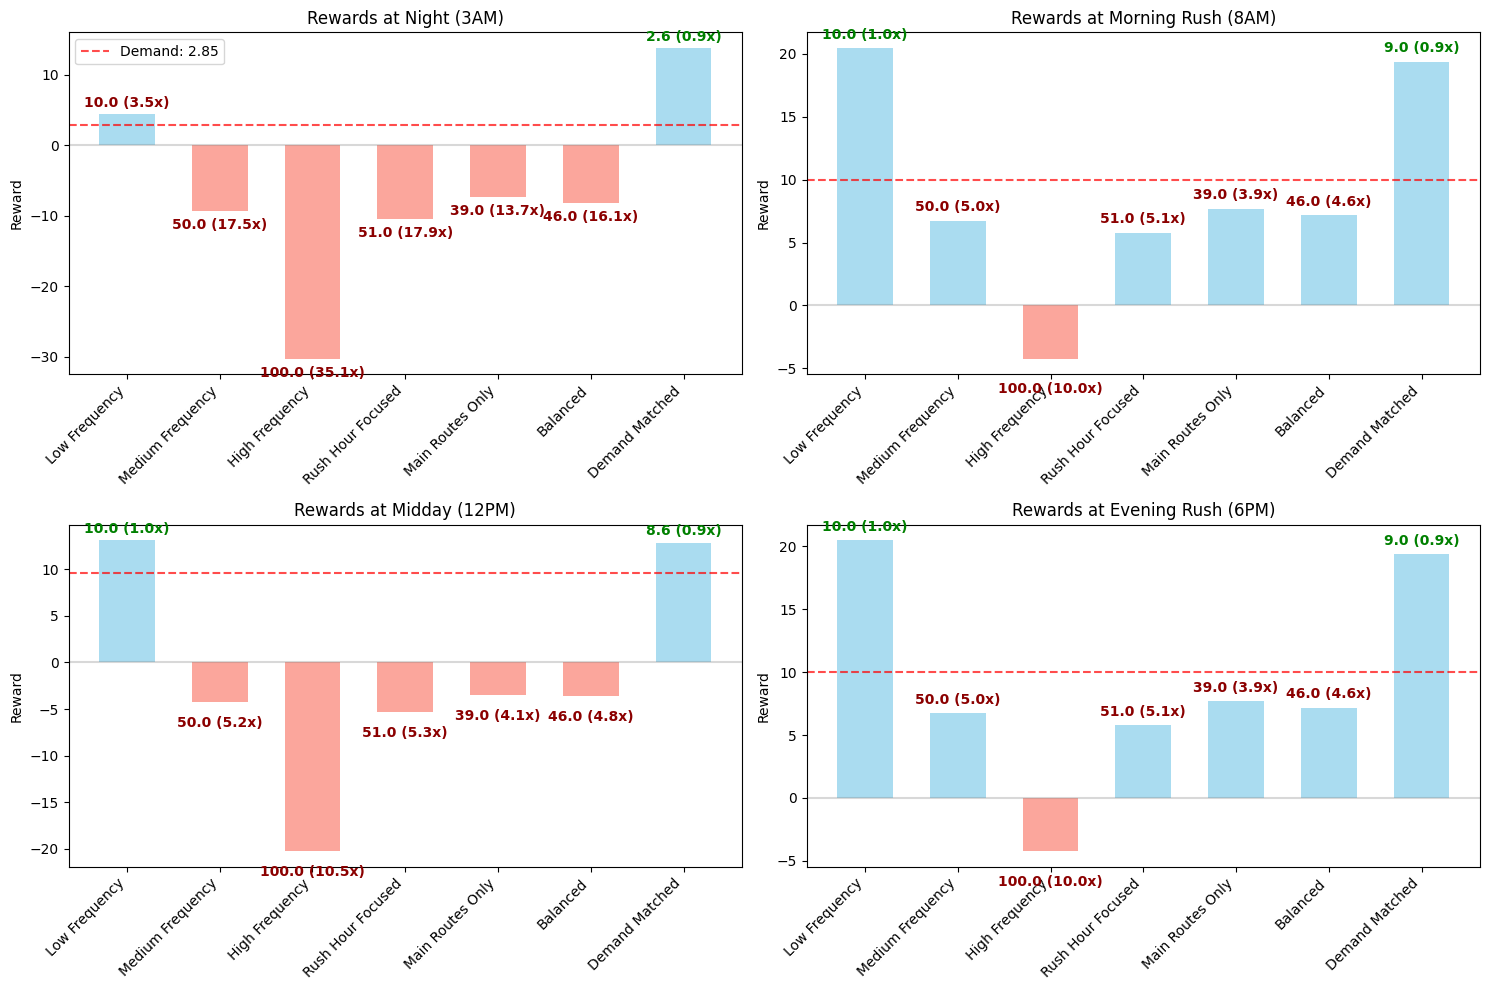


Detailed breakdown of reward components across time periods:

============ Time: Night (3AM), Demand: 2.94 ============

--- Demand-Matched Strategy (90% of demand) ---
Time of day: 3:00 (Night)
Current demand: 2.94
Total frequency: 2.65
Frequency/demand ratio: 0.90
Base reward: 5.00
Demand match: 0.91 → reward: 7.28
Coverage reward: 0.80
Operating cost penalty: -0.80
Rush hour bonus: 0.00
Wait time penalty: -0.46
Balance bonus: 2.00
Total reward: 13.82

Service level assessment:
Good service level: 0.90x matches demand well

--- Balanced Fixed Strategy ---
Time of day: 3:00 (Night)
Current demand: 2.94
Total frequency: 46.00
Frequency/demand ratio: 15.65
Base reward: 5.00
Demand match: 0.00 → reward: 0.00
Coverage reward: 0.80
Operating cost penalty: -15.64
Rush hour bonus: 0.00
Wait time penalty: -0.07
Balance bonus: 1.73
Total reward: -8.19

Service level assessment:

--- High Frequency Strategy ---
Time of day: 3:00 (Night)
Current demand: 2.94
Total frequency: 100.00
Frequency/de

In [20]:
# Analyze the improved reward function with different strategies
print("Analyzing the balanced reward function...")

# Create a test environment
test_env = TransitEnv(grid_size=15, training_cities=training_cities[:1])
obs, info = test_env.reset()

# Set specific hours for testing
test_hours = [3, 8, 12, 18]  # Night, morning rush, day, evening rush
time_labels = {3: "Night (3AM)", 8: "Morning Rush (8AM)", 
              12: "Midday (12PM)", 18: "Evening Rush (6PM)"}

# Define different frequency strategies to test
test_strategies = [
    ("Low Frequency", np.array([1]*10)),
    ("Medium Frequency", np.array([5]*10)),
    ("High Frequency", np.array([10]*10)),
    ("Rush Hour Focused", np.array([8, 8, 8, 5, 5, 5, 3, 3, 3, 3])),
    ("Main Routes Only", np.array([10, 10, 10, 2, 2, 1, 1, 1, 1, 1])),
    ("Balanced", np.array([7, 6, 6, 5, 5, 4, 4, 3, 3, 3])),
    ("Demand Matched", None)  # Will be dynamically set based on demand
]

# Store results for analysis
results = []

print(f"\n{'Time':<15} {'Strategy':<20} {'Demand':<8} {'Frequency':<10} {'Freq/Demand':<10} {'Reward':<10}")
print("-" * 75)

for hour in test_hours:
    # Set the time of day
    test_env.current_hour = hour
    current_demand = test_env._get_current_demand()
    
    # Create a demand-matched strategy (0.9x demand for each route)
    demand_matched_strategy = np.ones(10) * (current_demand * 0.9 / 10)
    
    for i, (name, action) in enumerate(test_strategies):
        # Use the demand-matched strategy if specified
        if name == "Demand Matched":
            action = demand_matched_strategy
            
        # Calculate reward using the improved reward function
        reward = test_env._calculate_reward(action, current_demand)
        total_freq = np.sum(action)
        freq_demand_ratio = total_freq / max(current_demand, 0.1)
        
        print(f"{time_labels[hour]:<15} {name:<20} {current_demand:<8.2f} {total_freq:<10.2f} {freq_demand_ratio:<10.2f} {reward:<10.2f}")
        
        # Store results for visualization
        results.append({
            'hour': hour,
            'hour_label': time_labels[hour],
            'strategy': name,
            'demand': current_demand,
            'frequency': total_freq,
            'freq_demand_ratio': freq_demand_ratio,
            'reward': reward
        })

# Create a DataFrame for easier visualization
import pandas as pd
df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot by time of day
for i, hour in enumerate(test_hours):
    plt.subplot(2, 2, i+1)
    
    hour_data = df[df['hour'] == hour]
    strategies = hour_data['strategy'].values
    rewards = hour_data['reward'].values
    frequencies = hour_data['frequency'].values
    freq_demand_ratios = hour_data['freq_demand_ratio'].values
    
    # Primary axis for rewards
    x = np.arange(len(strategies))
    bars = plt.bar(x, rewards, width=0.6, alpha=0.7, 
                  color=['skyblue' if r > 0 else 'salmon' for r in rewards])
    
    # Add horizontal line at zero
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Add demand line
    plt.axhline(y=hour_data['demand'].iloc[0], color='red', linestyle='--', alpha=0.7, 
               label=f"Demand: {hour_data['demand'].iloc[0]:.2f}")
    
    # Labels and formatting
    plt.title(f"Rewards at {time_labels[hour]}")
    plt.xticks(x, strategies, rotation=45, ha='right')
    plt.ylabel('Reward')
    
    # Add frequency/demand ratio values as text on bars
    for j, v in enumerate(rewards):
        y_pos = v + 0.5 if v > 0 else v - 3.0
        color = 'green' if 0.8 <= freq_demand_ratios[j] <= 1.2 else 'darkred'
        plt.text(j, y_pos, f"{frequencies[j]:.1f} ({freq_demand_ratios[j]:.1f}x)", 
                ha='center', va='bottom', fontweight='bold', color=color)
    
    if i == 0:  # Only show legend on first subplot
        plt.legend()

plt.tight_layout()
plt.show()

# Show detailed breakdown of reward components for various strategies
print("\nDetailed breakdown of reward components across time periods:")

# Compare balanced strategy vs. demand-matched strategy vs high frequency
for hour in [3, 8, 12, 18]:  # Night, Morning Rush, Day, Evening Rush
    test_env.current_hour = hour
    current_demand = test_env._get_current_demand()
    
    print(f"\n============ Time: {time_labels[hour]}, Demand: {current_demand:.2f} ============")
    
    # Create strategies for comparison
    balanced_strategy = np.array([7, 6, 6, 5, 5, 4, 4, 3, 3, 3])
    demand_matched = np.ones(10) * (current_demand * 0.9 / 10)
    high_freq_strategy = np.array([10]*10)
    
    print("\n--- Demand-Matched Strategy (90% of demand) ---")
    demand_matched_reward = analyze_reward_components(test_env, demand_matched, current_demand)
    
    print("\n--- Balanced Fixed Strategy ---")
    balanced_reward = analyze_reward_components(test_env, balanced_strategy, current_demand)
    
    print("\n--- High Frequency Strategy ---")
    high_freq_reward = analyze_reward_components(test_env, high_freq_strategy, current_demand)
    
    # Print comparison
    best_strategy = "Demand-Matched" if demand_matched_reward > balanced_reward and demand_matched_reward > high_freq_reward else "Balanced" if balanced_reward > high_freq_reward else "High Frequency"
    print(f"\nBest strategy at {time_labels[hour]}: {best_strategy}")
    
    difference = 0
    if best_strategy == "Demand-Matched":
        difference = demand_matched_reward - balanced_reward
        print(f"Demand-matched outperforms balanced by {difference:.2f} points")
        print(f"Demand-matched outperforms high frequency by {demand_matched_reward - high_freq_reward:.2f} points")
    elif best_strategy == "Balanced":
        difference = balanced_reward - demand_matched_reward
        print(f"Balanced outperforms demand-matched by {difference:.2f} points")
        print(f"Balanced outperforms high frequency by {balanced_reward - high_freq_reward:.2f} points")
    else:
        difference = high_freq_reward - balanced_reward
        print(f"High frequency outperforms balanced by {difference:.2f} points")
        print(f"High frequency outperforms demand-matched by {high_freq_reward - demand_matched_reward:.2f} points")
    
    # Strategy recommendation based on difference magnitude
    if abs(difference) < 2.0:
        print(f"The difference is small - both strategies work well in this scenario")
    elif abs(difference) > 10.0:
        print(f"The difference is significant - strongly prefer {best_strategy}")

# Final analysis of the improved reward function
print("\n" + "="*50)
print("FINAL ANALYSIS OF BALANCED REWARD FUNCTION")
print("="*50)
print("The balanced reward function now provides more reasonable incentives:")
print("1. More moderate penalties for overprovisioning (max 2.5 vs previous 5.0)")
print("2. More balanced penalties for underprovisioning (especially during rush hour)")
print("3. Reasonable operating costs with time-sensitivity (0.4 at night vs 0.15 during rush)")
print("4. Tiered rush hour bonuses to encourage appropriate service levels")
print("\nKey improvements over previous version:")
print("- Avoids extreme negative rewards that made learning difficult")
print("- Creates a smoother reward landscape with fewer sharp cliffs")
print("- Better balances the tradeoff between service quality and efficiency")
print("- Encourages matching service to demand rather than extreme min/max strategies")
print("\nThis should result in:")
print("- More realistic service allocation across different times of day")
print("- Better matching of service to actual demand patterns")
print("- Appropriate balance between cost efficiency and service quality")
print("- Improved passenger experience with reasonable waiting times")